In [10]:
# # Visualize it
%matplotlib ipympl
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objects as go
import SimpleITK as sitk
import trimesh
from IPython.display import display
from ipywidgets import interactive, widgets
from scipy.ndimage import binary_fill_holes, distance_transform_edt

from imgtools.ops import Resize


def mesh_to_voxels(filepath: str, resolution: int = 1024, pad: int = 5) -> sitk.Image:
	"""
	Load a 3D model and convert it to a filled voxel representation with edge fading.

	Parameters
	----------
	filepath : str
		Path to the .glb or .gltf file.
	resolution : int, optional
		Resolution of the voxel grid (higher = finer details).
	pad : int, optional
		Amount of padding to add around the voxelized object.

	Returns
	-------
	sitk.Image
		3D SimpleITK image with voxel intensities ranging from 0 (background) to 0.8 (inner regions).
	"""
	# Load mesh
	mesh = trimesh.load_mesh(filepath)

	# Get voxel grid
	voxel_grid = mesh.voxelized(pitch=mesh.scale / resolution)
	voxel_array = voxel_grid.matrix.astype(np.uint8)

	# Fill internal holes to ensure a solid object
	voxel_filled = binary_fill_holes(voxel_array).astype(np.uint8)

	# Apply a distance transform inside the filled object
	distances = distance_transform_edt(voxel_filled)

	# Normalize distances (0 at edges, max at center)
	distances = distances / np.max(distances)
	# Convert to intensity (center = 1, edge = 0.8) for non-zero distances
	voxel_intensity = np.where(distances > 0, 0.7 + (distances * 0.1), 0)

	# Rotate counterclockwise along z-axis
	voxel_intensity = np.rot90(voxel_intensity, 1, (0, 1))

	# Pad the array to ensure no clipping at edges
	voxel_padded = np.pad(voxel_intensity, pad_width=pad, mode="constant", constant_values=0)

	# Convert to SimpleITK Image
	simage = sitk.GetImageFromArray(voxel_padded)

	return simage

In [11]:

image: sitk.Image = mesh_to_voxels("rubber_inflatable_duck.glb", resolution=128)
print(image.GetSize())
resizer = Resize(size = 100, interpolation='linear')
image = resizer(image)


image = sitk.Flip(image, [True, True, True])

(89, 95, 69)


In [12]:


class VoxelVisualizer:
	"""
	Class for visualizing voxelized 3D models with both 2D slice views and 3D rendering.

	Attributes
	----------
	image : np.ndarray
		3D numpy array representing the filled voxel model.
	slices_x : list of np.ndarray
		Precomputed YZ slices along the X-axis.
	slices_y : list of np.ndarray
		Precomputed XZ slices along the Y-axis.
	slices_z : list of np.ndarray
		Precomputed XY slices along the Z-axis.
	slice_images_x : list of matplotlib Figures
		Precomputed Matplotlib figures for YZ slices.
	slice_images_y : list of matplotlib Figures
		Precomputed Matplotlib figures for XZ slices.
	slice_images_z : list of matplotlib Figures
		Precomputed Matplotlib figures for XY slices.
	"""
	def __init__(self, image: np.ndarray) -> None:
		"""
		Initialize the voxel visualizer with a precomputed voxel array
		and precompute 2D slice images.

		Parameters
		----------
		image : np.ndarray
			3D numpy array representing the filled voxel model.
		"""
		match image:
			case sitk.Image():
				self.image = sitk.GetArrayFromImage(image)
			case np.ndarray():
				self.image = image

		# Compute slices
		self.slices_x = [self.image[i, :, :] for i in range(self.image.shape[0])]
		self.slices_y = [self.image[:, i, :] for i in range(self.image.shape[1])]
		self.slices_z = [self.image[:, :, i] for i in range(self.image.shape[2])]

		# Store max indices and start positions
		self.max_x, self.max_y, self.max_z = self.image.shape[0] - 1, self.image.shape[1] - 1, self.image.shape[2] - 1
		self.start_x, self.start_y, self.start_z = self.max_x // 2, self.max_y // 2, self.max_z // 2
		# get the vmax of the image
		self.vmax = np.max(self.image)
		self.vmin = np.min(self.image)
		# Precompute Matplotlib figures
		self.slice_images_x = self._precompute_images(self.slices_x, "YZ Slice")
		self.slice_images_y = self._precompute_images(self.slices_y, "XZ Slice")
		self.slice_images_z = self._precompute_images(self.slices_z, "XY Slice")


	def _precompute_images(self, slices: list[np.ndarray], title_prefix: str) -> list[plt.Figure]:
		"""
		Precompute Matplotlib figures for all slices.

		Parameters
		----------
		slices : list of np.ndarray
			List of 2D slices to visualize.
		title_prefix : str
			Title prefix for the slice (e.g., "YZ Slice").

		Returns
		-------
		list of plt.Figure
			List of precomputed Matplotlib figures.
		"""
		figs = []
		for i, slice_img in enumerate(slices):
			fig, ax = plt.subplots(figsize=(5, 5))
			ax.imshow(slice_img, vmax = self.vmax, vmin = self.vmin)
			ax.set_title(f"{title_prefix} {i}")
			ax.axis("off")
			figs.append(fig)
			plt.close(fig)  # Close to prevent rendering during initialization
		return figs

	def visualize_slices(self) -> None:
		"""
		Display an interactive widget for selecting precomputed slices.
		"""
		# Sliders
		slice_slider_x = widgets.IntSlider(value=self.start_x, min=0, max=self.max_x, step=1, description=f"X Slice ({self.max_x + 1} total):")
		slice_slider_y = widgets.IntSlider(value=self.start_y, min=0, max=self.max_y, step=1, description=f"Y Slice ({self.max_y + 1} total):")
		slice_slider_z = widgets.IntSlider(value=self.start_z, min=0, max=self.max_z, step=1, description=f"Z Slice ({self.max_z + 1} total):")

		# Output areas for displaying images
		output_x = widgets.Output()
		output_y = widgets.Output()
		output_z = widgets.Output()

		def update_slices(change: None = None) -> None:
			# Update slice views by displaying precomputed images
			with output_x:
				output_x.clear_output(wait=True)
				display(self.slice_images_x[slice_slider_x.value])

			with output_y:
				output_y.clear_output(wait=True)
				display(self.slice_images_y[slice_slider_y.value])

			with output_z:
				output_z.clear_output(wait=True)
				display(self.slice_images_z[slice_slider_z.value])

		# Observe slider changes
		slice_slider_x.observe(update_slices, names="value")
		slice_slider_y.observe(update_slices, names="value")
		slice_slider_z.observe(update_slices, names="value")

		# Initial display
		update_slices()

		# Display sliders and image outputs
		display(slice_slider_x, output_x, slice_slider_y, output_y, slice_slider_z, output_z)

	def visualize_3d(self) -> None:
		"""
		Visualize the voxelized 3D object using Plotly Scatter3d.
		"""
		# Extract voxel positions where the object exists
		x, y, z = np.where(self.image > 0)
		values = self.image[x, y, z]  # Extract voxel values for coloring

		# Create a colormap
		colors = np.array(['blue' if val <= 1 else 'red' for val in values])

		# Create a 3D scatter plot
		fig = go.Figure(data=go.Scatter3d(
			x=x, y=y, z=z,
			mode='markers',
			marker=dict(
				size=1,  # Size of each voxel
				color=colors,  # Color based on voxel values
				opacity=0.1  # Transparency
			)
		))

		# Adjust layout
		fig.update_layout(scene=dict(
			xaxis=dict(nticks=10, range=[0, self.image.shape[0]]),
			yaxis=dict(nticks=10, range=[0, self.image.shape[1]]),
			zaxis=dict(nticks=10, range=[0, self.image.shape[2]]),
		),
		title="3D Voxelized Model"
		)
		
		fig.show()



In [13]:
# Example usage
visualizer = VoxelVisualizer(image) 

# visualizer.visualize_slices()


IntSlider(value=49, description='X Slice (100 total):', max=99)

Output()

IntSlider(value=49, description='Y Slice (100 total):', max=99)

Output()

IntSlider(value=49, description='Z Slice (100 total):', max=99)

Output()

In [14]:
star_image = mesh_to_voxels("star.glb", resolution=128, pad=10)
resizer = Resize(size = 20, interpolation='linear', anti_alias=True)
star_image = resizer(star_image)

# flip image on Y axis
star_image = sitk.Flip(star_image, [False, True, False])

# star_visualizer = VoxelVisualizer(star_image)

# star_visualizer.visualize_slices()



In [17]:
import numpy as np
import SimpleITK as sitk


def insert_star_into_duck(
    duck: sitk.Image, star: sitk.Image, position: tuple[int, int, int]
) -> tuple[sitk.Image, sitk.Image]:
    """
    Insert a star-shaped voxel object into a larger duck volume at a specified position.

    Parameters
    ----------
    duck : sitk.Image
        The 3D SimpleITK image of the duck.
    star : sitk.Image
        The 3D SimpleITK image of the star.
    position : tuple[int, int, int]
        The (x, y, z) coordinates where the star should be placed inside the duck.

    Returns
    -------
    tuple[sitk.Image, sitk.Image]
        A tuple containing:
        - The modified duck image with the star embedded.
        - A binary mask image where the star is represented as 1, and the rest is 0.
    """
    # Convert to NumPy arrays
    duck_array = sitk.GetArrayFromImage(duck)
    star_array = sitk.GetArrayFromImage(star)

    # Create an empty mask array
    mask_array = np.zeros_like(duck_array, dtype=np.uint8)
    
    # Convert star values greater than 0 to 2 in the duck
    star_array[star_array > 0] = 1

    # Get dimensions
    dx, dy, dz = duck_array.shape
    sx, sy, sz = star_array.shape
    px, py, pz = position  # Position where the star will be inserted

    # Ensure the star fits within the duck volume
    if px + sx > dx or py + sy > dy or pz + sz > dz:
        raise ValueError("Star does not fit inside the duck at the specified position!")

    # Insert star into the duck array (preserving intensity values)
    duck_array[px:px + sx, py:py + sy, pz:pz + sz] = np.maximum(
        duck_array[px:px + sx, py:py + sy, pz:pz + sz], star_array
    )
    
    # duck_array values are between 0 and 1
    # we want to convert them to 0 and 255
    duck_array = (duck_array * 255).astype(np.uint8)

    # Create binary mask for the star
    # mask_array[px:px + sx, py:py + sy, pz:pz + sz] = (star_array == 2).astype(np.uint8)
    # get the binary mask from the new duckarray

    mask_array = (duck_array == 2).astype(np.uint8)


    # Convert back to SimpleITK images
    merged_duck = sitk.GetImageFromArray(duck_array)
    mask_image = sitk.GetImageFromArray(mask_array)

    return merged_duck, mask_image


merged_image, mask_image = insert_star_into_duck(image, star_image, position=(65, 20, 40))

merged_path = "merged_duck_with_star.nii.gz"
mask_path = "star_mask.nii.gz"

sitk.WriteImage(merged_image, merged_path)
sitk.WriteImage(mask_image, mask_path)

print(f"{merged_image.GetSize()} {mask_image.GetSize()}")

merged_visualizer = VoxelVisualizer(merged_image)

merged_visualizer.visualize_slices()


(100, 100, 100) (100, 100, 100)


IntSlider(value=49, description='X Slice (100 total):', max=99)

Output()

IntSlider(value=49, description='Y Slice (100 total):', max=99)

Output()

IntSlider(value=49, description='Z Slice (100 total):', max=99)

Output()

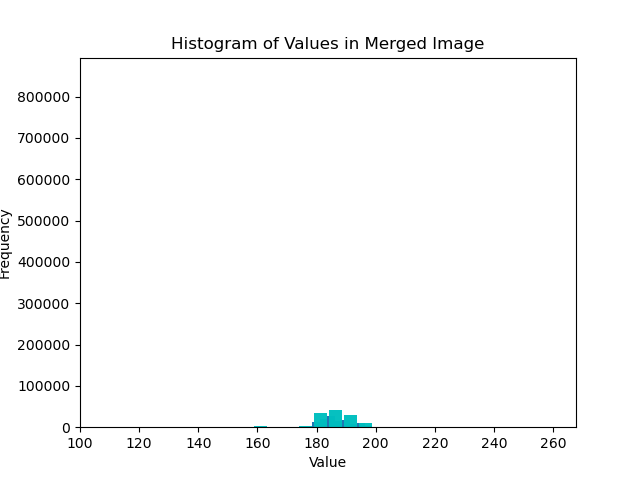

In [25]:
# histogram of values in the merged image that are greater than or equal to 1

merged_array = sitk.GetArrayFromImage(merged_image)
merged_array = merged_array[merged_array >= 1]

plt.hist(merged_array, bins=50, color='c', alpha=0.7, rwidth=0.85)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Values in Merged Image')
plt.xlim(left=100)  # Set the lower limit of x-axis to be greater than 100

plt.show()